In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import e
connection = sqlite3.connect('file:database.db?mode=ro', uri=True)

# market_orders = pd.read_sql_query("SELECT * FROM market_orders", connection)
market_history = pd.read_sql_query("SELECT * FROM market_history", connection)

market_history = market_history.sort_values(by=['date'])

connection.close()

In [109]:
item_34 = market_history.loc[market_history['item_id'] == 17715]
item_34 = item_34.loc[item_34['region_id'] == 10000002]

item_34

,id,date,item_id,region_id,low_price,high_price,average_price,order_count,volume
1257410,1257411,2022-09-01,17715,10000002,248500000.0,249400000.0,248800000.0,155,164
1257411,1257412,2022-09-02,17715,10000002,255100000.0,260000000.0,259800000.0,158,170
1257412,1257413,2022-09-03,17715,10000002,240800000.0,259500000.0,258900000.0,174,203
1257413,1257414,2022-09-04,17715,10000002,239000000.0,254600000.0,249600000.0,167,183
1257414,1257415,2022-09-05,17715,10000002,249200000.0,250000000.0,249800000.0,214,221
...,...,...,...,...,...,...,...,...,...
1257800,1257801,2023-09-28,17715,10000002,276100000.0,276950000.0,276500000.0,178,195
1257801,1257802,2023-09-29,17715,10000002,276000000.0,276900000.0,276700000.0,171,180
1257802,1257803,2023-09-30,17715,10000002,276900000.0,277850000.0,277100000.0,194,219
1257803,1257804,2023-10-01,17715,10000002,271950000.0,277900000.0,277050000.0,175,196


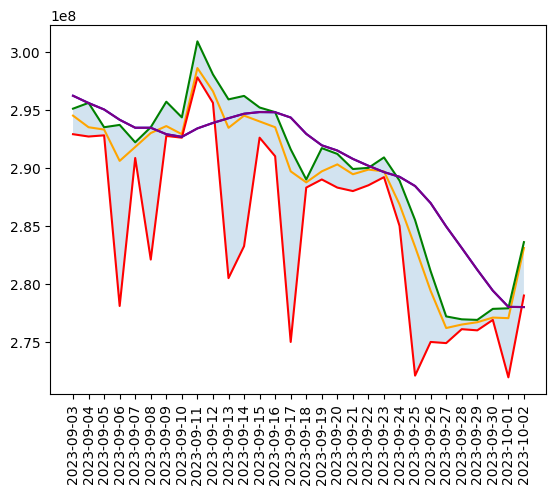

In [113]:
last_30_days = item_34.tail(30)
rolling_7 = item_34['average_price'].rolling(7).mean().tail(30)
rolling_30 = item_34['average_price'].rolling(30).mean().tail(30)

plt.figure()
plt.plot(last_30_days['date'], last_30_days['average_price'], label='average_price', color='orange')
plt.plot(last_30_days['date'], last_30_days['low_price'], label='average_price', color='red')
plt.plot(last_30_days['date'], last_30_days['high_price'], label='average_price', color='green')
plt.plot(last_30_days['date'], rolling_7, label='average_price', color='blue')
plt.plot(last_30_days['date'], rolling_30, label='average_price', color='purple')

plt.fill_between(last_30_days['date'], last_30_days['low_price'], last_30_days['high_price'], alpha=0.2)
plt.xticks(rotation=90)
plt.show()


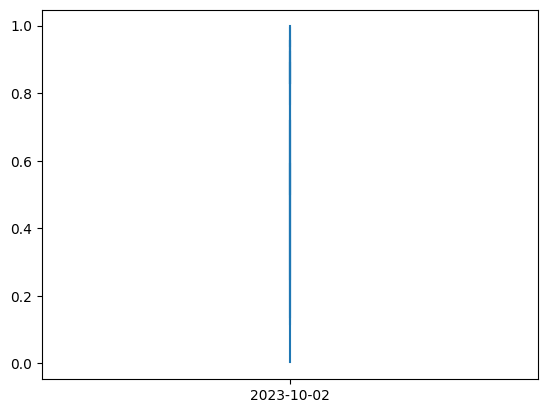

In [107]:
last_30_days = item_34.tail(30)
difference = last_30_days['high_price'] - last_30_days['low_price']
relative_to_low = last_30_days['average_price'] - last_30_days['low_price']
relative = relative_to_low / difference
plt.figure()

# plt.plot(last_30_days['date'], difference, label='average_price')
plt.plot(last_30_days['date'], relative, label='average_price')

plt.show()

In [96]:
g_sum = market_history.groupby('item_id')['average_price'].transform('sum')
values = market_history['average_price'] / g_sum
market_history['entropy'] = -(values*np.log(values))
market_history['entropy'] = market_history['entropy'].fillna(0)
df = market_history.groupby('item_id')['entropy'].sum()
df = df.sort_values(ascending=False)
df

item_id
30747    6.672033
30746    6.672033
30745    6.672033
30744    6.672033
60771    6.672033
           ...   
53205    0.000000
37485    0.000000
36288    0.000000
36289    0.000000
40332    0.000000
Name: entropy, Length: 14849, dtype: float64